<a href="https://colab.research.google.com/github/ntanthedev/captcha-solver/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import các thư viện**

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from collections import Counter
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import model_from_json
import base64
import time
import requests
import io
from PIL import Image
import urllib

**Tải file data_zip lên**

In [3]:
# Get the current working directory
current_directory = Path("./data/")

# Iterate through all files in the directory
# for filename in os.listdir(current_directory):
#     # Get the filename length
#     filename_length = len(filename)

#     # Check if the filename length is 6 characters different
#     if filename_length != 10:
#         # Print the filename
#         print(filename)
#         # Use the `os.remove()` function to delete the file
#         os.remove(Path("./data/"+filename))

In [4]:
data_dir = Path("./data/")

# Get a list of all files in the data directory
files = list(data_dir.glob("*"))

# Filter the list to include only files with extensions .jpg and .png
images = [file for file in files if file.suffix in [".jpg", ".png"]]

# Sort the list of images
images = sorted(list(map(str, images)))

labels = [
    img.split(os.path.sep)[-1].split(".")[0] for img in images
]

characters = set(char for label in labels for char in label)
characters = sorted(list(characters))

print("Number of images found: ", len(images))
print("Number of labels found: ", len(labels))
print("Number of unique characters: ", len(characters))
print("Characters present: ", characters)
# Batch size for training and validation
batch_size = 16

# Desired image dimensions
img_width = 150
img_height = 50

# Factor by which the image is going to be downsampled
# by the convolutional blocks. We will be using two
# convolution blocks and each block will have
# a pooling layer which downsample the features by a factor of 2.
# Hence total downsampling factor would be 4.
downsample_factor = 4

# Maximum length of any captcha in the dataset
max_length = max([len(label) for label in labels])
print("Max length: ", max_length)

Number of images found:  1287
Number of labels found:  1287
Number of unique characters:  28
Characters present:  ['2', '3', '4', '5', '6', '7', '8', '9', 'b', 'c', 'd', 'f', 'g', 'h', 'j', 'k', 'm', 'n', 'p', 'q', 'r', 's', 't', 'v', 'w', 'x', 'y', 'z']
Max length:  6


**Tùy theo characters bạn cần thì đưa vào**

In [5]:
characters_mbbank = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'd', 'e', 'f', 'g', 'h', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

In [6]:
# Mapping characters to integers
char_to_num = layers.StringLookup(
    vocabulary=list(characters_mbbank), mask_token=None
)

# Mapping integers back to original characters
num_to_char = layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)


def split_data(images, labels, train_size=0.9, shuffle=True):
    # 1. Get the total size of the dataset
    size = len(images)
    # 2. Make an indices array and shuffle it, if required
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)
    # 3. Get the size of training samples
    train_samples = int(size * train_size)
    # 4. Split data into training and validation sets
    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]]
    return x_train, x_valid, y_train, y_valid


# Splitting data into training and validation sets
x_train, x_valid, y_train, y_valid = split_data(np.array(images), np.array(labels))


def encode_single_sample(img_path, label):
    # 1. Read image
    img = tf.io.read_file(img_path)
    # 2. Decode and convert to grayscale
    img = tf.io.decode_png(img, channels=1)
    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. Resize to the desired size
    img = tf.image.resize(img, [img_height, img_width])
    # 5. Transpose the image because we want the time
    # dimension to correspond to the width of the image.
    img = tf.transpose(img, perm=[1, 0, 2])
    # 6. Map the characters in label to numbers
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    # 7. Return a dict as our model is expecting two inputs
    return {"image": img, "label": label}

In [7]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (
    train_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
validation_dataset = (
    validation_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

InvalidArgumentError: {{function_node __wrapped__IteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} Cannot add tensor to the batch: number of elements does not match. Shapes are: [tensor]: [4], [batch]: [5] [Op:IteratorGetNext] name: 

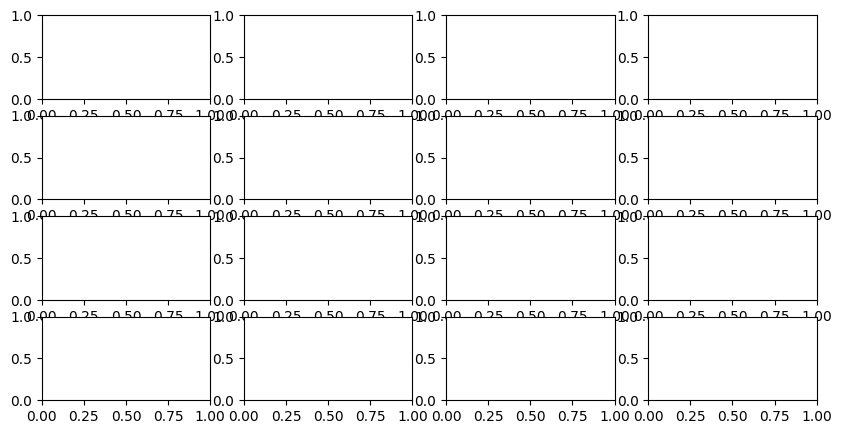

In [8]:
_, ax = plt.subplots(4, 4, figsize=(10, 5))
for batch in train_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]

    for i in range(16):
        img = (images[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
plt.show()

In [ ]:
class CustomLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred


def build_model():
    # Inputs to the model
    input_img = layers.Input(
        shape=(img_width, img_height, 1), name="image", dtype="float32"
    )
    labels = layers.Input(name="label", shape=(None,), dtype="float32")

    # First conv block
    x = layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block
    x = layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model
    new_shape = ((img_width // 4), (img_height // 4) * 64)
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.2)(x)

    # RNNs
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    # Output layer
    x = layers.Dense(
        len(char_to_num.get_vocabulary()) + 1, activation="softmax", name="dense2"
    )(x)

    # Add CTC layer for calculating CTC loss at each step
    output = CustomLayer(name="ctc_loss")(labels, x)

    # Define the model
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="model"
    )
    # Optimizer
    opt = keras.optimizers.Adam()
    # Compile the model and return
    model.compile(optimizer=opt)
    return model


# Get the model
model = build_model()
model.summary()

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)        │ (None, 160, 60, 1)     │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 160, 60, 32)    │            320 │ image[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 80, 30, 32)     │              0 │ Conv1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv2 (Conv2D)            │ (None, 80, 30, 64)     │         18,496 │ pool1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool2 (MaxPooling2D)      │ (None, 40, 15, 64)     │              0 │ Conv2[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 40, 960)        │              0 │ pool2[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense1 (Dense)            │ (None, 40, 64)         │         61,504 │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 40, 64)         │              0 │ dense1[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 40, 256)        │        197,632 │ dropout[0][0]          │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_1           │ (None, 40, 128)        │        164,352 │ bidirectional[0][0]    │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ label (InputLayer)        │ (None, None)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense2 (Dense)            │ (None, 40, 61)         │          7,869 │ bidirectional_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ ctc_loss (CustomLayer)    │ (None, 40, 61)         │              0 │ label[0][0],           │
│                           │                        │                │ dense2[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 450,173 (1.72 MB)

 Trainable params: 450,173 (1.72 MB)

 Non-trainable params: 0 (0.00 B)

**Chỗ này có thể để epochs cao lên để train chính xác dần lên.**

In [ ]:
epochs = 1000
early_stopping_patience = 100
# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[early_stopping],
)

Epoch 1/1000
43/43 ━━━━━━━━━━━━━━━━━━━━ 14s 118ms/step - loss: 848.2296 - val_loss: 374.8965
Epoch 2/1000
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - loss: 388.6180 - val_loss: 370.5237
Epoch 3/1000
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - loss: 385.1567 - val_loss: 369.3468
Epoch 4/1000
43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 94ms/step - loss: 384.5369 - val_loss: 369.6807
Epoch 5/1000
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - loss: 384.1924 - val_loss: 369.0732
Epoch 6/1000
43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step - loss: 383.9190 - val_loss: 369.1215
Epoch 7/1000
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 107ms/step - loss: 383.7178 - val_loss: 368.7086
Epoch 8/1000
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - loss: 383.5752 - val_loss: 368.7234
Epoch 9/1000
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 132ms/step - loss: 383.3119 - val_loss: 368.8853
Epoch 10/1000
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - loss: 383.0715 - val_loss: 369.2332
Epoch 11/1000
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - loss: 382.9360 - val_loss:

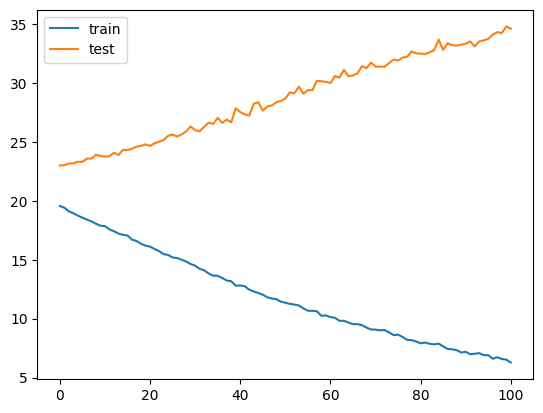

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
def SaveModel(file, model):
    # JSON format
    xfile = os.path.splitext(file)
    if (xfile[1] == ".json"):
        print("save JSON:", file)
        json_model = model.to_json()
        with open(file, "w") as json:
            json.write(json_model)
        model.save_weights(xfile[0] + ".wgt")
    # Keras format
    elif (xfile[1] == ".h5" or xfile[1] == ".dnn"):
        print("save HDF5:", file)
        model.save(file, save_format='h5', save_traces=False)

    # TF format
    else:
        print("save TF:", file)
        model.save(file, save_format='tf', save_traces=False)

In [ ]:
def LoadModel(file):
    # JSON format
    xfile = os.path.splitext(file)
    if (xfile[1] == ".json"):
        with open(file, "r") as json:
            json_model = json.read()
        model = keras.models.model_from_json(json_model)
        model.load_weights(xfile[0] + ".wgt")

    # ONNX format
    elif (xfile[1] == ".onnx"):
        raise Exception("LoadModel; ONNX format not supported yet")
        model = None

    # TF/Keras format
    else:
        model = keras.models.load_model(file, custom_objects={'leaky_relu': tf.nn.leaky_relu})

    return model

**Chỗ này là save model ra các file. chú ý các file mới sau khi save là biết model gồm những gì**

In [ ]:
# Get the prediction model by extracting layers till the output layer
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
SaveModel("captcha.json", prediction_model)

ValueError: `inputs` argument cannot be empty. Received:
inputs=[]
outputs=<KerasTensor shape=(None, 40, 61), dtype=float32, sparse=False, name=keras_tensor_9>

**Load model lên và thử hình từ validation_dataset mình từng load ở bên trên.**

1/1 [==============================] - 1s 1s/step


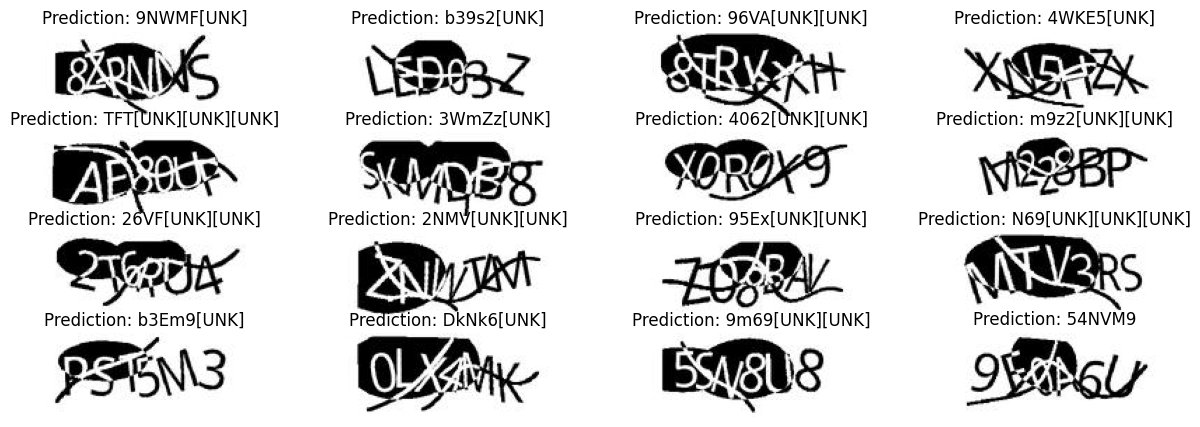

In [ ]:
import cv2
model_mbbank = LoadModel("captcha.json")

# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_length
    ]
    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

#  Let's check results on some validation samples
for batch in validation_dataset.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = model_mbbank.predict(batch_images)

    file_names = [file for file in os.listdir("data")]
    pred_texts = decode_batch_predictions(preds)

    orig_texts = []
    for label in batch_labels:
      label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
      orig_texts.append(label)

    _, ax = plt.subplots(4, 4, figsize=(15, 5))


    for i in range(len(pred_texts)):
      img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
      img = img.T
      title = f"Prediction: {pred_texts[i]}"
      ax[i // 4, i % 4].imshow(img, cmap="gray")
      ax[i // 4, i % 4].set_title(title)
      ax[i // 4, i % 4].axis("off")

Code chạy model riêng cho các bạn tham khảo. Copy 4 file checkpoint, captcha.json, index và 000000 gì đó vào folder content mà chạy. Chuẩn bị folder imgs có hình trong đó.

[link](https://colab.research.google.com/drive/1--PO5PmKlIEtRxq4RJHsH_dqDcuFGpIY?usp=sharing)

Full sourve:
[Link](https://www.youtube.com/watch?v=VUEb8swYRfM&list=PL33lvabfss1xvlwhuEZLyeq7Xg3_F8nOJ&index=1)